In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
import keras.layers as tfl
import seaborn as sn
import dataset

In [2]:
# interfacce function to get splited dataset
# resize all audio to (19, 1841) matrix
# 1841 is the max size of Japanese audio
dataset_collection = dataset.getMFCCDatasetRAVDESS(train_size = 0.6, valid_size = 0.2, test_size = 0.2, cut = False, emotion_number = 3, max_len = 1841)

X_train = dataset_collection['X_train']
Y_train = dataset_collection['Y_train']
X_valid = dataset_collection['X_valid']
Y_valid = dataset_collection['Y_valid']
X_test = dataset_collection['X_test']
Y_test = dataset_collection['Y_test']

X_train_norm = dataset_collection['X_train_norm']
X_valid_norm = dataset_collection['X_valid_norm']
X_test_norm = dataset_collection['X_test_norm']

f:\Shitford\Lectures\22fall\CS230\cs230\dataset.py:49: RuntimeWarning: invalid value encountered in true_divide
  X_train_norm = (X_train - X_train_miu)/X_train_std
f:\Shitford\Lectures\22fall\CS230\cs230\dataset.py:50: RuntimeWarning: invalid value encountered in true_divide
  X_valid_norm = (X_valid - X_valid_miu)/X_valid_std
f:\Shitford\Lectures\22fall\CS230\cs230\dataset.py:51: RuntimeWarning: invalid value encountered in true_divide
  X_test_norm = (X_test - X_test_miu)/X_test_std


In [3]:
print(dataset_collection)
print(X_train.shape)

{'X_train': array([[[  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        ...,
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ]],

       [[ 27.539936 ,  35.60782  ,  26.701862 , ...,   0.       ,
           0.       ,   0.       ],
        [ -1.7654216, -11.484297 , -15.572038 , ...,   0.       ,
           0.       ,   0.       ],
        [  2.0748258,  -0.4502632,  -5.4781218, ...,   0.       ,
           0.       ,   0.       ],
        ...,
        [  1.3535737,   7.551132 ,   8.056

In [4]:
# convert array to tensor
X_train_norm = tf.convert_to_tensor(X_train_norm)
X_valid_norm = tf.convert_to_tensor(X_valid_norm)
X_test_norm = tf.convert_to_tensor(X_test_norm)
Y_train = tf.convert_to_tensor(Y_train)
Y_valid = tf.convert_to_tensor(Y_valid)
Y_test = tf.convert_to_tensor(Y_test)

X_train = tf.convert_to_tensor(X_train)
X_valid = tf.convert_to_tensor(X_valid)
X_test = tf.convert_to_tensor(X_test)

In [5]:
def convolutional_model(input_shape):
        """
        Implements the forward propagation for the model:
        CONV2D -> RELU -> MAXPOOL -> CONV2D -> Softmax -> MAXPOOL -> FLATTEN -> DENSE
        
        Arguments:
        input_mfcc -- input dataset, of shape (input_shape)

        Returns:
        model -- TF Keras model (object containing the information for the entire training process) 
        """

        input_mfcc = tf.keras.Input(shape=input_shape)
        ## CONV1D: 4 filters 8, stride of 1, padding 'SAME'
        Z1 = tfl.Conv1D(filters = 8, kernel_size = 4, strides = 2, padding='same', kernel_initializer = 'he_normal', kernel_regularizer = 'L1')(input_mfcc)
        ## RELU
        A1 = tfl.LeakyReLU()(Z1)
        ## MAXPOOL: window 8, stride 4, padding 'SAME'
        P1 = tfl.MaxPool1D(pool_size = 8, strides = 4, padding='same')(A1)
        
        # D1 = tfl.Dropout(0.2)(P1)

        ## CONV1D: 2 filters 4, stride 1, padding 'SAME'
        Z2 = tfl.Conv1D(filters = 4, kernel_size = 4, strides = 2, padding='same', kernel_initializer = 'he_normal', kernel_regularizer = 'L1')(P1)
        ## RELU
        A2 = tfl.LeakyReLU()(Z2)
        ## MAXPOOL: window 4, stride 2, padding 'SAME'
        P2 = tfl.MaxPool1D(pool_size = 4, strides = 2, padding='same')(A2)

        # D2 = tfl.Dropout(0.2)(P2)

        # ## CONV1D: 2 filters 4, stride 1, padding 'SAME'
        # Z3 = tfl.Conv1D(filters = 2, kernel_size = 4, strides = 2, padding='same', kernel_initializer = 'he_normal', kernel_regularizer = 'L1')(D2)
        # ## RELU
        # A3 = tfl.ReLU()(Z3)
        # ## MAXPOOL: window 4, stride 2, padding 'SAME'
        # P3 = tfl.MaxPool1D(pool_size = 4, strides = 2, padding='same')(A3)

        # D3 = tfl.Dropout(0.2)(P3)

        ## FLATTEN
        F = tfl.Flatten()(P2)
        # D3 = tfl.Dropout(0.2)(F)
        ## Dense layer
        ## 6 neurons in output layer. Hint: one of the arguments should be "activation='softmax'" 
        # Den1 = tfl.Dense(64, activation='ReLU', kernel_regularizer = 'L1')(F)
        outputs = tfl.Dense(3, activation='softmax')(F)
        model = tf.keras.Model(inputs=input_mfcc, outputs=outputs)
        return model


In [6]:
# conv_model = CNN_RAVDESS.CNN.convolutional_model((512, 19))
conv_model = convolutional_model((19, 1841))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 19, 1841)]        0         
                                                                 
 conv1d (Conv1D)             (None, 10, 8)             58920     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 10, 8)             0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 8)             0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 4)              132       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 2, 4)              0         
                                                             

In [7]:
print(X_train_norm.shape)

(287, 19, 1841)


In [8]:
history = conv_model.fit(X_train_norm, Y_train, epochs=100, validation_data=(X_valid_norm, Y_valid))

Epoch 1/100
9/9 [==============================] - 5s 109ms/step - loss: 7.9412 - accuracy: 0.4007 - val_loss: 5.9773 - val_accuracy: 0.4000
Epoch 2/100
9/9 [==============================] - 0s 28ms/step - loss: 4.9840 - accuracy: 0.4111 - val_loss: 4.0296 - val_accuracy: 0.4211
Epoch 3/100
9/9 [==============================] - 0s 32ms/step - loss: 3.4454 - accuracy: 0.4286 - val_loss: 3.0410 - val_accuracy: 0.4632
Epoch 4/100
9/9 [==============================] - 0s 34ms/step - loss: 2.6510 - accuracy: 0.4913 - val_loss: 2.5707 - val_accuracy: 0.4737
Epoch 5/100
9/9 [==============================] - 0s 34ms/step - loss: 2.2735 - accuracy: 0.5122 - val_loss: 2.2888 - val_accuracy: 0.4947
Epoch 6/100
9/9 [==============================] - 0s 35ms/step - loss: 1.9888 - accuracy: 0.5679 - val_loss: 2.0711 - val_accuracy: 0.4737
Epoch 7/100
9/9 [==============================] - 0s 33ms/step - loss: 1.7974 - accuracy: 0.5993 - val_loss: 1.9162 - val_accuracy: 0.4737
Epoch 8/100
9/9 [==

E:\Anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

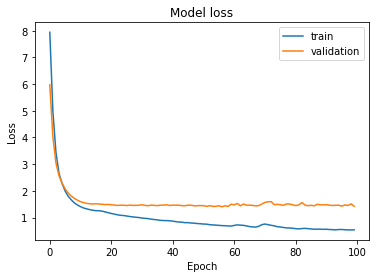

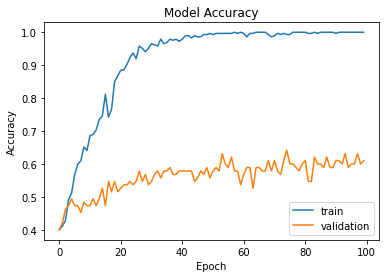

In [9]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(6,4)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(6,4)).set(xlabel='Epoch',ylabel='Accuracy')

Build transfer model

apply it on Japanese dataset

In [10]:
dataset_collection = dataset.getMFCCDataset(train_size = 0.6, valid_size = 0.2, test_size = 0.2, cut = False, max_len = 1841)

jap_X_train = dataset_collection['X_train']
jap_Y_train = dataset_collection['Y_train']
jap_X_valid = dataset_collection['X_valid']
jap_Y_valid = dataset_collection['Y_valid']
jap_X_test = dataset_collection['X_test']
jap_Y_test = dataset_collection['Y_test']

jap_X_train_norm = dataset_collection['X_train_norm']
jap_X_valid_norm = dataset_collection['X_valid_norm']
jap_X_test_norm = dataset_collection['X_test_norm']

# convert array to tensor
jap_X_train_norm = tf.convert_to_tensor(jap_X_train_norm)
jap_X_valid_norm = tf.convert_to_tensor(jap_X_valid_norm)
jap_X_test_norm = tf.convert_to_tensor(jap_X_test_norm)
jap_Y_train = tf.convert_to_tensor(jap_Y_train)
jap_Y_valid = tf.convert_to_tensor(jap_Y_valid)
jap_Y_test = tf.convert_to_tensor(jap_Y_test)

jap_X_train = tf.convert_to_tensor(jap_X_train)
jap_X_valid = tf.convert_to_tensor(jap_X_valid)
jap_X_test = tf.convert_to_tensor(jap_X_test)

In [11]:
def transfer_model(japanese_input_size):
    conv_model.trainable = False
    inputs = tf.keras.Input(japanese_input_size)
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = conv_model(inputs, training=False) 
    
    x = tf.keras.layers.Reshape((1,3))(x)
    # # add the new Binary classification layers
    # # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    # # include dropout with probability of 0.2 to avoid overfitting
    # x = tf.keras.layers.Dropout(0.2)(x)
    # # use a prediction layer with three neuron (as three emotions in Japanese dataset)
    outputs = tf.keras.layers.Dense(3)(x)
    
    
    model = tf.keras.Model(inputs, outputs)

    return model

In [12]:
base_learning_rate = 0.01
jap_transfer_model = transfer_model((19, 1841))
jap_transfer_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
jap_transfer_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 19, 1841)]        0         
                                                                 
 model (Functional)          (None, 3)                 59067     
                                                                 
 reshape (Reshape)           (None, 1, 3)              0         
                                                                 
 global_average_pooling1d (G  (None, 3)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
Total params: 59,079
Trainable params: 12
Non-trainable params: 59,067
______________________________________________________

E:\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
jap_history = jap_transfer_model.fit(jap_X_train_norm, jap_Y_train, epochs=100, validation_data=(jap_X_valid_norm, jap_Y_valid))

Epoch 1/100
17/17 [==============================] - 3s 55ms/step - loss: 5.1838 - accuracy: 0.3556 - val_loss: 3.9937 - val_accuracy: 0.3944
Epoch 2/100
17/17 [==============================] - 0s 18ms/step - loss: 5.0793 - accuracy: 0.3537 - val_loss: 4.1901 - val_accuracy: 0.4000
Epoch 3/100
17/17 [==============================] - 0s 15ms/step - loss: 4.7397 - accuracy: 0.3796 - val_loss: 4.4034 - val_accuracy: 0.4667
Epoch 4/100
17/17 [==============================] - 0s 18ms/step - loss: 4.1959 - accuracy: 0.4000 - val_loss: 3.9377 - val_accuracy: 0.4667
Epoch 5/100
17/17 [==============================] - 0s 17ms/step - loss: 3.6385 - accuracy: 0.4019 - val_loss: 3.3072 - val_accuracy: 0.4444
Epoch 6/100
17/17 [==============================] - 0s 16ms/step - loss: 3.2607 - accuracy: 0.4037 - val_loss: 2.8263 - val_accuracy: 0.4167
Epoch 7/100
17/17 [==============================] - 0s 16ms/step - loss: 2.8794 - accuracy: 0.3815 - val_loss: 2.4370 - val_accuracy: 0.3889
Epoch 

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

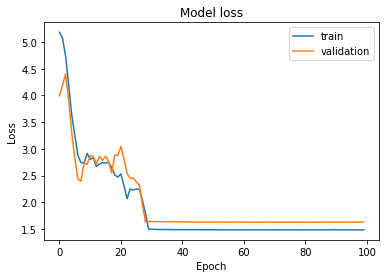

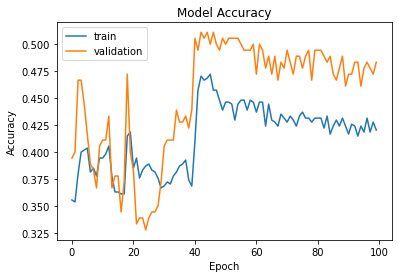

In [14]:
df_loss_acc = pd.DataFrame(jap_history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(6,4)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(6,4)).set(xlabel='Epoch',ylabel='Accuracy')

Fine tune

In [18]:
# the 2nd layer is CNN layer in conv_model
base_conv_model = jap_transfer_model.layers[1]
base_conv_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_conv_model.layers))

# Fine-tune from this layer onwards
# total layer number in conv_model is 9
fine_tune_at = 6

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_conv_model.layers[:fine_tune_at]:
    layer.trainable = False

jap_transfer_model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.1 * base_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
jap_transfer_model.summary()

Number of layers in the base model:  9
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 19, 1841)]        0         
                                                                 
 model (Functional)          (None, 3)                 59067     
                                                                 
 reshape (Reshape)           (None, 1, 3)              0         
                                                                 
 global_average_pooling1d (G  (None, 3)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
Total params: 59,079
Trainable params: 27
Non-trainable params: 59,052
_______________

In [19]:
jap_transfer_history = conv_model.fit(jap_X_train_norm, jap_Y_train, epochs=20, validation_data=(jap_X_valid_norm, jap_Y_valid))

Epoch 1/20
17/17 [==============================] - 1s 30ms/step - loss: 3.2623 - accuracy: 0.8981 - val_loss: 3.6478 - val_accuracy: 0.6778
Epoch 2/20
17/17 [==============================] - 0s 26ms/step - loss: 2.8093 - accuracy: 0.8981 - val_loss: 3.5095 - val_accuracy: 0.7389
Epoch 3/20
17/17 [==============================] - 0s 26ms/step - loss: 2.4934 - accuracy: 0.9556 - val_loss: 2.9798 - val_accuracy: 0.7333
Epoch 4/20
17/17 [==============================] - 0s 26ms/step - loss: 1.9711 - accuracy: 0.9778 - val_loss: 2.3738 - val_accuracy: 0.7444
Epoch 5/20
17/17 [==============================] - 0s 27ms/step - loss: 1.5041 - accuracy: 0.9907 - val_loss: 1.8882 - val_accuracy: 0.7833
Epoch 6/20
17/17 [==============================] - 0s 28ms/step - loss: 1.2132 - accuracy: 0.9889 - val_loss: 1.6904 - val_accuracy: 0.7444
Epoch 7/20
17/17 [==============================] - 0s 23ms/step - loss: 0.9899 - accuracy: 0.9944 - val_loss: 1.4351 - val_accuracy: 0.7778
Epoch 8/20
17

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

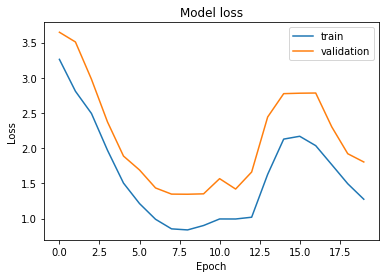

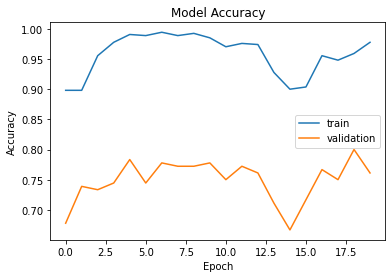

In [20]:
df_loss_acc = pd.DataFrame(jap_transfer_history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(6,4)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(6,4)).set(xlabel='Epoch',ylabel='Accuracy')